# Multi-LLM Collaborative Debate System - Analysis

This notebook visualizes the experiment results from the debate system.

## Metrics Analyzed:
1. **Overall Accuracy** - How often the final answer is correct
2. **Judge Accuracy vs Majority Vote** - Compare judge selection vs consensus
3. **Collaboration Bonus** - Did refinement improve answers?
4. **Accuracy by Category** - Performance across Math, Logic, Physics, etc.

In [16]:
import json
from pathlib import Path
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## 1. Load Data

Load results from `data/results_log.json`. If missing or empty, generate dummy data.

In [17]:
RESULTS_PATH = Path("../data/results_log.json")

def generate_dummy_data() -> list[dict]:
    """Generate dummy data for visualization testing."""
    dummy_results = [
        {
            "problem_id": 1,
            "category": "Logic",
            "difficulty": "Hard",
            "question": "Sample logic puzzle",
            "ground_truth": "Answer A",
            "judge_id": "C",
            "solver_ids": ["A", "B", "D"],
            "initial_solutions": {
                "A": {"final_answer": "Answer A"},
                "B": {"final_answer": "Answer B"},
                "D": {"final_answer": "Answer A"},
            },
            "refined_solutions": {
                "A": {"final_answer": "Answer A"},
                "B": {"final_answer": "Answer A"},
                "D": {"final_answer": "Answer A"},
            },
            "verdict": {"best_solver_id": "A", "final_answer_to_user": "Answer A"},
            "evaluation": {"is_correct": True, "reasoning": "Correct"},
        },
        {
            "problem_id": 2,
            "category": "Math",
            "difficulty": "Medium",
            "question": "Sample math problem",
            "ground_truth": "42",
            "judge_id": "A",
            "solver_ids": ["B", "C", "D"],
            "initial_solutions": {
                "B": {"final_answer": "42"},
                "C": {"final_answer": "41"},
                "D": {"final_answer": "42"},
            },
            "refined_solutions": {
                "B": {"final_answer": "42"},
                "C": {"final_answer": "42"},
                "D": {"final_answer": "42"},
            },
            "verdict": {"best_solver_id": "B", "final_answer_to_user": "42"},
            "evaluation": {"is_correct": True, "reasoning": "Correct"},
        },
        {
            "problem_id": 3,
            "category": "Physics",
            "difficulty": "Medium",
            "question": "Sample physics problem",
            "ground_truth": "51.3",
            "judge_id": "D",
            "solver_ids": ["A", "B", "C"],
            "initial_solutions": {
                "A": {"final_answer": "50.0"},
                "B": {"final_answer": "51.3"},
                "C": {"final_answer": "52.0"},
            },
            "refined_solutions": {
                "A": {"final_answer": "51.0"},
                "B": {"final_answer": "51.3"},
                "C": {"final_answer": "51.3"},
            },
            "verdict": {"best_solver_id": "B", "final_answer_to_user": "51.3"},
            "evaluation": {"is_correct": True, "reasoning": "Correct"},
        },
        {
            "problem_id": 4,
            "category": "Math",
            "difficulty": "Hard",
            "question": "Sample hard math problem",
            "ground_truth": "1024",
            "judge_id": "B",
            "solver_ids": ["A", "C", "D"],
            "initial_solutions": {
                "A": {"final_answer": "1000"},
                "C": {"final_answer": "1024"},
                "D": {"final_answer": "1000"},
            },
            "refined_solutions": {
                "A": {"final_answer": "1000"},
                "C": {"final_answer": "1024"},
                "D": {"final_answer": "1024"},
            },
            "verdict": {"best_solver_id": "A", "final_answer_to_user": "1000"},
            "evaluation": {"is_correct": False, "reasoning": "Incorrect"},
        },
        {
            "problem_id": 5,
            "category": "Logic",
            "difficulty": "Hard",
            "question": "Sample hard logic problem",
            "ground_truth": "July 16",
            "judge_id": "A",
            "solver_ids": ["B", "C", "D"],
            "initial_solutions": {
                "B": {"final_answer": "July 16"},
                "C": {"final_answer": "Aug 17"},
                "D": {"final_answer": "July 14"},
            },
            "refined_solutions": {
                "B": {"final_answer": "July 16"},
                "C": {"final_answer": "July 16"},
                "D": {"final_answer": "July 16"},
            },
            "verdict": {"best_solver_id": "B", "final_answer_to_user": "July 16"},
            "evaluation": {"is_correct": True, "reasoning": "Correct"},
        },
    ]
    return dummy_results


def load_results() -> list[dict]:
    """Load results from JSON file or return dummy data."""
    if RESULTS_PATH.exists():
        with open(RESULTS_PATH, "r") as f:
            data = json.load(f)
            if data and len(data) > 0:
                # Filter out error entries
                valid_data = [r for r in data if "evaluation" in r]
                if valid_data:
                    print(f"Loaded {len(valid_data)} results from {RESULTS_PATH}")
                    return valid_data
    
    print("No valid results found. Using dummy data for visualization.")
    return generate_dummy_data()


results = load_results()
print(f"Total results: {len(results)}")

Loaded 25 results from ../data/results_log.json
Total results: 25


## 2. Flatten Data into DataFrame

In [18]:
def flatten_results(results: list[dict]) -> pd.DataFrame:
    """Flatten nested JSON results into a DataFrame."""
    rows = []
    
    for r in results:
        solver_ids = r.get("solver_ids", [])
        initial_solutions = r.get("initial_solutions", {})
        refined_solutions = r.get("refined_solutions", {})
        ground_truth = r.get("ground_truth", "")
        
        # Count how many initial answers match ground truth (simplified check)
        initial_correct_count = sum(
            1 for sid in solver_ids
            if ground_truth.lower() in initial_solutions.get(sid, {}).get("final_answer", "").lower()
        )
        
        # Count how many refined answers match ground truth
        refined_correct_count = sum(
            1 for sid in solver_ids
            if ground_truth.lower() in refined_solutions.get(sid, {}).get("final_answer", "").lower()
        )
        
        # Get majority vote from refined solutions
        refined_answers = [refined_solutions.get(sid, {}).get("final_answer", "") for sid in solver_ids]
        answer_counts = Counter(refined_answers)
        majority_answer = answer_counts.most_common(1)[0][0] if answer_counts else ""
        majority_would_be_correct = ground_truth.lower() in majority_answer.lower() if majority_answer else False
        
        row = {
            "problem_id": r.get("problem_id"),
            "category": r.get("category", "Unknown"),
            "difficulty": r.get("difficulty", "Unknown"),
            "judge_id": r.get("judge_id"),
            "num_solvers": len(solver_ids),
            "initial_correct_count": initial_correct_count,
            "refined_correct_count": refined_correct_count,
            "final_answer": r.get("verdict", {}).get("final_answer_to_user", ""),
            "best_solver_id": r.get("verdict", {}).get("best_solver_id", ""),
            "is_correct": r.get("evaluation", {}).get("is_correct", False),
            "majority_answer": majority_answer,
            "majority_would_be_correct": majority_would_be_correct,
            "collaboration_improved": refined_correct_count > initial_correct_count,
        }
        rows.append(row)
    
    return pd.DataFrame(rows)


df = flatten_results(results)
df.head()

,problem_id,category,difficulty,judge_id,num_solvers,initial_correct_count,refined_correct_count,final_answer,best_solver_id,is_correct,majority_answer,majority_would_be_correct,collaboration_improved
0,1,Logic,Hard,B,3,0,0,"The first question to ask is: ""If I were to as...",C,False,"""If I asked you 'Is B Random?', would you say ...",False,False
1,2,Math,Medium,D,3,3,3,The last two digits of 7^{2024} are 01.,A,True,01,True,False
2,3,Physics,Medium,D,3,3,2,The minimum angle the ladder can make with the...,A,True,51.3 degrees,True,False
3,4,Game Theory,Hard,C,3,0,0,Bidder A's optimal bidding strategy is to bid ...,B,True,$100,False,False
4,5,Logic,Hard,C,3,3,3,Cheryl's birthday is July 16.,A,True,July 16,True,False


## 3. Calculate Key Metrics

In [19]:
# Overall Accuracy
overall_accuracy = df["is_correct"].mean() * 100
print(f"Overall Accuracy: {overall_accuracy:.1f}%")

# Judge Accuracy (how often judge's pick was correct)
judge_accuracy = df["is_correct"].mean() * 100
print(f"Judge Selection Accuracy: {judge_accuracy:.1f}%")

# Majority Vote Accuracy
majority_accuracy = df["majority_would_be_correct"].mean() * 100
print(f"Majority Vote Accuracy: {majority_accuracy:.1f}%")

# Collaboration Bonus (did refinement help?)
collaboration_bonus = df["collaboration_improved"].mean() * 100
print(f"Collaboration Bonus (refinement improved): {collaboration_bonus:.1f}%")

# Accuracy by Category
print("\nAccuracy by Category:")
category_accuracy = df.groupby("category")["is_correct"].mean() * 100
print(category_accuracy.round(1))

Overall Accuracy: 80.0%
Judge Selection Accuracy: 80.0%
Majority Vote Accuracy: 48.0%
Collaboration Bonus (refinement improved): 4.0%

Accuracy by Category:
category
Game Theory    100.0
Logic           71.4
Math            87.5
Physics         50.0
Probability    100.0
Name: is_correct, dtype: float64


## 4. Visualization: Accuracy by Problem Category

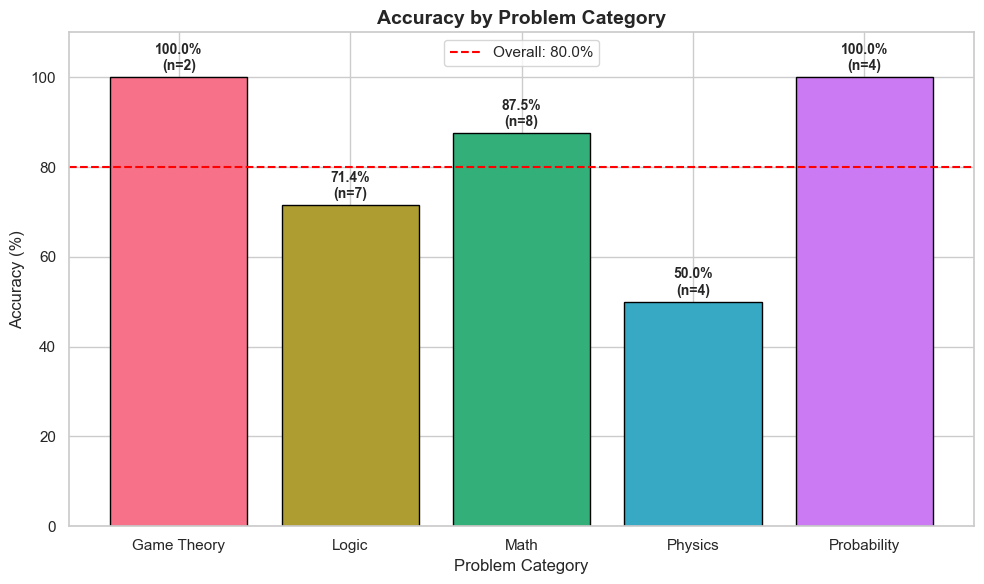

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate accuracy by category
category_stats = df.groupby("category").agg(
    accuracy=("is_correct", "mean"),
    count=("is_correct", "count")
).reset_index()
category_stats["accuracy"] = category_stats["accuracy"] * 100

# Create bar chart
colors = sns.color_palette("husl", len(category_stats))
bars = ax.bar(category_stats["category"], category_stats["accuracy"], color=colors, edgecolor="black")

# Add value labels on bars
for bar, count in zip(bars, category_stats["count"]):
    height = bar.get_height()
    ax.annotate(
        f"{height:.1f}%\n(n={count})",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

ax.set_xlabel("Problem Category", fontsize=12)
ax.set_ylabel("Accuracy (%)", fontsize=12)
ax.set_title("Accuracy by Problem Category", fontsize=14, fontweight="bold")
ax.set_ylim(0, 110)
ax.axhline(y=overall_accuracy, color="red", linestyle="--", label=f"Overall: {overall_accuracy:.1f}%")
ax.legend()

plt.tight_layout()
plt.show()

## 5. Visualization: Judge vs Majority Vote Comparison

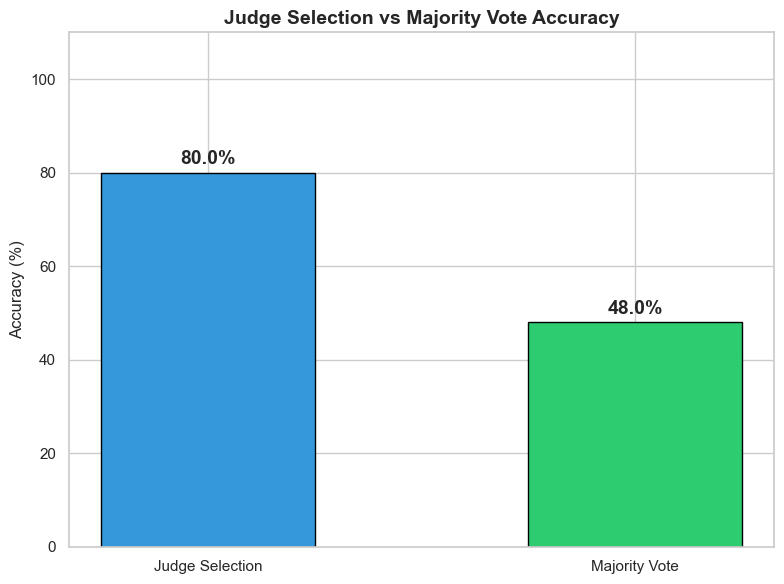

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

methods = ["Judge Selection", "Majority Vote"]
accuracies = [judge_accuracy, majority_accuracy]
colors = ["#3498db", "#2ecc71"]

bars = ax.bar(methods, accuracies, color=colors, edgecolor="black", width=0.5)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{height:.1f}%",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
    )

ax.set_ylabel("Accuracy (%)", fontsize=12)
ax.set_title("Judge Selection vs Majority Vote Accuracy", fontsize=14, fontweight="bold")
ax.set_ylim(0, 110)

plt.tight_layout()
plt.show()

## 6. Visualization: Initial vs Final Answer Correctness (Confusion Matrix)

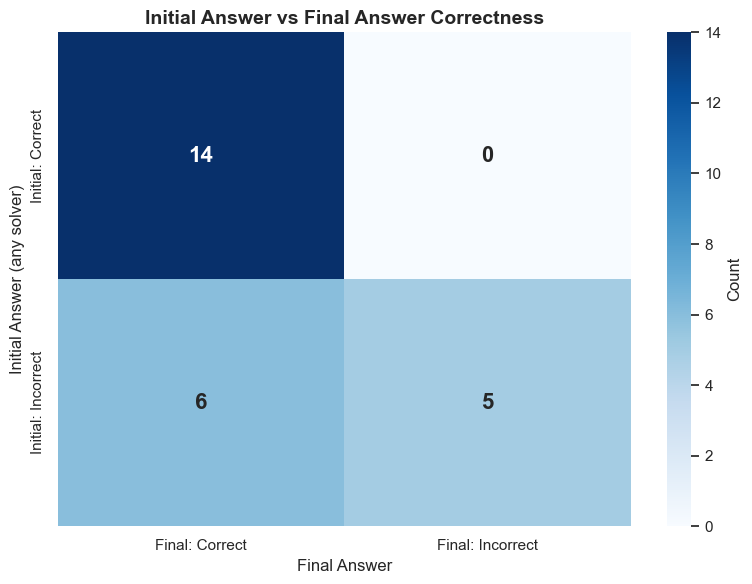

In [22]:
# Create a confusion-style matrix:
# Rows: Initial had correct answer (at least one solver)
# Cols: Final answer correct

df["initial_had_correct"] = df["initial_correct_count"] > 0

# Create confusion matrix
confusion_data = pd.crosstab(
    df["initial_had_correct"].map({True: "Initial: Correct", False: "Initial: Incorrect"}),
    df["is_correct"].map({True: "Final: Correct", False: "Final: Incorrect"}),
)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    confusion_data,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax,
    cbar_kws={"label": "Count"},
    annot_kws={"size": 16, "weight": "bold"},
)

ax.set_title("Initial Answer vs Final Answer Correctness", fontsize=14, fontweight="bold")
ax.set_xlabel("Final Answer", fontsize=12)
ax.set_ylabel("Initial Answer (any solver)", fontsize=12)

plt.tight_layout()
plt.show()

## 7. Visualization: Collaboration Bonus (Refinement Impact)

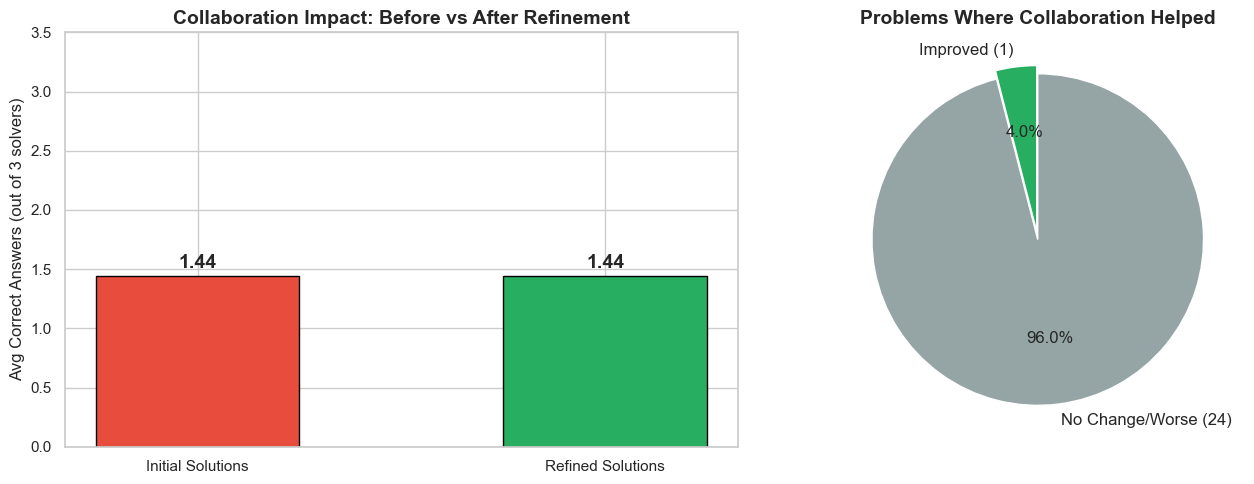

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Average correct answers before/after refinement
avg_initial = df["initial_correct_count"].mean()
avg_refined = df["refined_correct_count"].mean()

ax1 = axes[0]
stages = ["Initial Solutions", "Refined Solutions"]
avg_correct = [avg_initial, avg_refined]
colors = ["#e74c3c", "#27ae60"]

bars = ax1.bar(stages, avg_correct, color=colors, edgecolor="black", width=0.5)
for bar in bars:
    height = bar.get_height()
    ax1.annotate(
        f"{height:.2f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
    )

ax1.set_ylabel("Avg Correct Answers (out of 3 solvers)", fontsize=12)
ax1.set_title("Collaboration Impact: Before vs After Refinement", fontsize=14, fontweight="bold")
ax1.set_ylim(0, 3.5)

# Right: Pie chart of improvement
ax2 = axes[1]
improved = df["collaboration_improved"].sum()
not_improved = len(df) - improved

ax2.pie(
    [improved, not_improved],
    labels=[f"Improved ({improved})", f"No Change/Worse ({not_improved})"],
    colors=["#27ae60", "#95a5a6"],
    autopct="%1.1f%%",
    startangle=90,
    explode=(0.05, 0),
    textprops={"fontsize": 12},
)
ax2.set_title("Problems Where Collaboration Helped", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

## 8. Summary Statistics Table

In [27]:
summary = pd.DataFrame({
    "Metric": [
        "Total Problems",
        "Overall Accuracy",
        "Judge Selection Accuracy",
        "Majority Vote Accuracy",
        "Collaboration Bonus Rate",
        "Avg Initial Correct (per problem)",
        "Avg Refined Correct (per problem)",
    ],
    "Value": [
        f"{len(df)}",
        f"{overall_accuracy:.1f}%",
        f"{judge_accuracy:.1f}%",
        f"{majority_accuracy:.1f}%",
        f"{collaboration_bonus:.1f}%",
        f"{avg_initial:.2f} / 3",
        f"{avg_refined:.2f} / 3",
    ],
})

display(summary)

,Metric,Value
0,Total Problems,25
1,Overall Accuracy,80.0%
2,Judge Selection Accuracy,80.0%
3,Majority Vote Accuracy,48.0%
4,Collaboration Bonus Rate,4.0%
5,Avg Initial Correct (per problem),1.44 / 3
6,Avg Refined Correct (per problem),1.44 / 3


## 9. Detailed Results Table

In [28]:
# Display key columns
display_cols = [
    "problem_id",
    "category",
    "difficulty",
    "judge_id",
    "best_solver_id",
    "is_correct",
    "initial_correct_count",
    "refined_correct_count",
    "collaboration_improved",
]

df[display_cols]

,problem_id,category,difficulty,judge_id,best_solver_id,is_correct,initial_correct_count,refined_correct_count,collaboration_improved
0,1,Logic,Hard,B,C,False,0,0,False
1,2,Math,Medium,D,A,True,3,3,False
2,3,Physics,Medium,D,A,True,3,2,False
3,4,Game Theory,Hard,C,B,True,0,0,False
4,5,Logic,Hard,C,A,True,3,3,False
5,6,Math,Hard,B,C,True,3,3,False
6,7,Probability,Medium,C,A,True,3,3,False
7,8,Math,Medium,A,Solver C,True,0,0,False
8,9,Physics,Medium,B,C,False,0,0,False
9,10,Logic,Hard,A,Solver C,True,0,0,False
